In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from d2l import torch as d2l
import torchvision.models as models
import torchvision

In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
class MyViT(nn.Module):
    def __init__(self, input_shape, n_patches=7, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()

        # Input and patches sizes
        self.input_shape = input_shape
        self.n_patches = n_patches
        self.n_heads = n_heads
        assert input_shape[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert input_shape[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (input_shape[1] / n_patches, input_shape[2] / n_patches)
        self.hidden_d = hidden_d

        # 1) Linear mapper
        self.input_d = int(input_shape[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        # (In forward method)

        # 4a) Layer normalization 1
        self.ln1 = nn.LayerNorm((self.n_patches ** 2 + 1, self.hidden_d))

        # 4b) Multi-head Self Attention (MSA) and classification token
        self.msa = MyMSA(self.hidden_d, n_heads)

        # 5a) Layer normalization 2
        self.ln2 = nn.LayerNorm((self.n_patches ** 2 + 1, self.hidden_d))

        # 5b) Encoder MLP
        self.enc_mlp = nn.Sequential(
            nn.Linear(self.hidden_d, self.hidden_d),
            nn.ReLU()
        )

        # 6) Classification MLP
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, w, h = images.shape
        patches = images.reshape(n, self.n_patches ** 2, self.input_d)

        # Running linear layer for tokenization
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

        # Adding positional embedding
        tokens += get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d).repeat(n, 1, 1).cuda()

        # TRANSFORMER ENCODER BEGINS ###################################
        # NOTICE: MULTIPLE ENCODER BLOCKS CAN BE STACKED TOGETHER ######
        # Running Layer Normalization, MSA and residual connection
        out = tokens + self.msa(self.ln1(tokens))

        # Running Layer Normalization, MLP and residual connection
        out = out + self.enc_mlp(self.ln2(out))
        # TRANSFORMER ENCODER ENDS   ###################################

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out)

In [4]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        self.k_mappings = [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        self.v_mappings = [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head].cuda()
                k_mapping = self.k_mappings[head].cuda()
                v_mapping = self.v_mappings[head].cuda()

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [5]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [6]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [7]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = Adam(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [8]:
def main():
    #设置参数
    device = d2l.try_gpu()
    batch_size, lr, num_epochs = 16, 0.01, 5
    data_dir = '../../数据/colon_image_sets'

    #数据处理
    train_path = data_dir + '/training'
    test_path = data_dir + '/testing'

    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.5,),(0.5,),(0.5,))])

    train_data = torchvision.datasets.ImageFolder(train_path,transform=transform)
    test_data = torchvision.datasets.ImageFolder(test_path,transform=transform)

    train_iter=torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
    test_iter=torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=True)
    
    #定义模型和训练模块
    model = MyViT((1, 28, 28), n_patches=7, hidden_d=20, n_heads=2, out_d=2)

    #训练
    train(model, train_iter, test_iter, num_epochs, lr, device)
    
    #保存模型
    torch.save(net,'C:/Users/17132/Desktop/model_ViT_colon_CT.pt')

training on cuda:0


RuntimeError: shape '[16, 49, 16]' is invalid for input of size 28311552

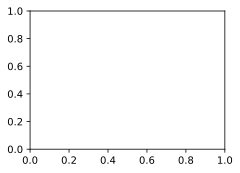

In [9]:
if __name__ == '__main__':
    main()